# Package installation

In [ ]:
# Enforce pytorch version 1.6.0
import torch
if torch.__version__ != '1.6.0':
  !pip uninstall torch -y
  !pip uninstall torchvision -y
  !pip install torch==1.6.0
  !pip install torchvision==0.7.0

# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version
!nvidia-smi

1.6.0
10.2
Python 3.7.10
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
#@title
# Install rdkit
!pip install mlflow
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
 
 
logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)
 
 
def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """
 
    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )
 
    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)
 
    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return
 
        logger.info("force re-install")
 
    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)
 
    logger.info("python version: {}".format(python_version))
 
    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)
 
    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')
 
    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')
 
    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python==3.7.3",
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")
 
    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))
 
 
if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
rdkit is already installed


In [ ]:
# If something breaks in the notebook it is probably related to a mismatch between the Python version, CUDA or torch
import torch
pytorch_version = f"torch-{torch.__version__}+cu{torch.version.cuda.replace('.', '')}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0+cu102.html


### Old

In [ ]:
####################################
#to jest to stare ale dzialajace
from torch.nn import Sequential, Linear, BatchNorm1d
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv
embedding_size = 512


class GAN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GAN, self).__init__()
        num_classes = 1
    
        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3) 
        #####################################################################################
        # wszystkie bloki moznaby bylo wrzucic jako jedna macierz
        #####################################################################################
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)

        # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024, num_classes)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # First block
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)
        
        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Second block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Third block
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Concat pooled vectors
        x = x1 + x2 + x3

#############################################################################
#Dac pooling layer z global attention layer: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
############################################################################

        # Output block
        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)
        out = torch.sigmoid(x)
        
        return out, x

In [ ]:
!pip install pyngrok --quiet
#from: https://stackoverflow.com/questions/61615818/setting-up-mlflow-on-google-colab
import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

# Dataset creation and exploration

## Loading and describing data

In [ ]:
import pandas as pd
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import rdmolops, Draw
import os

In [ ]:
# source of data: http://moleculenet.ai/datasets-1
smile_path = 'drive/MyDrive/Molecule project/Data/raw/'
smile_name = 'BBBP.csv'

smile = pd.read_csv(os.path.join(smile_path, smile_name))
smile.head()

,num,name,p_np,smiles
0,1,Propanolol,1.0,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1.0,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1.0,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1.0,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1.0,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [ ]:
smile.drop(labels=['num', 'name'], axis=1, inplace=True)
print(smile.shape)
print(smile['p_np'].value_counts()) 

(2030, 2)
1.0    1550
0.0     479
Name: p_np, dtype: int64


In [ ]:
#Setting weights for loss function
weight_for_one = sum(smile['p_np']== 0.0) / len(smile)
weight_for_zero = sum(smile['p_np'] == 1.0) / len(smile)
weights = torch.tensor([weight_for_zero, weight_for_one])

print('Weight for positive prediction: ', weight_for_one)
print('Weight for negative prediction: ', weight_for_zero)

Weight for positive prediction:  0.23596059113300494
Weight for negative prediction:  0.7635467980295566


## Molecule visualization

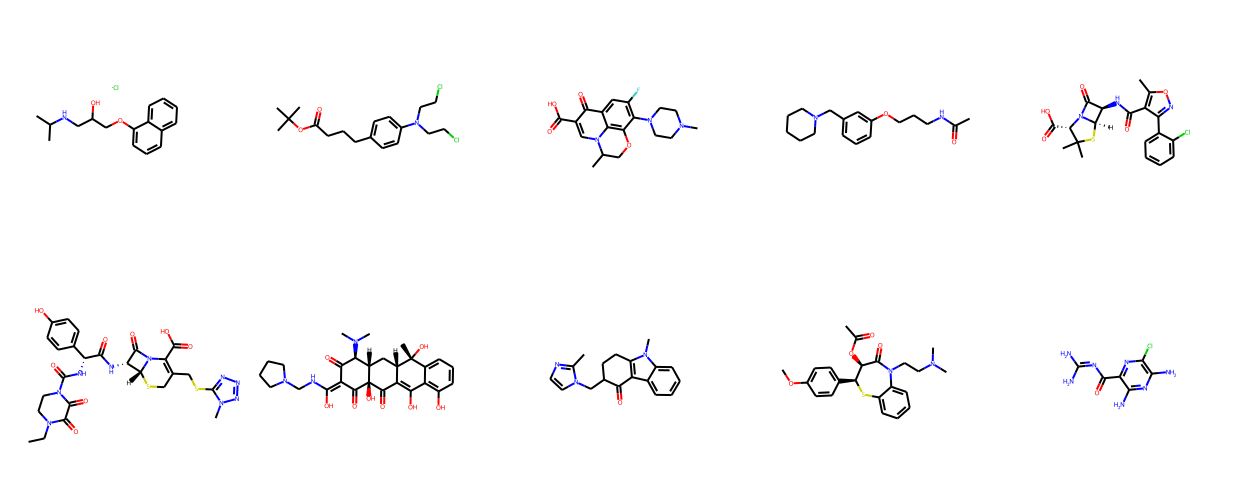

In [ ]:
first_ten = smile["smiles"][:10].values
first_ten = [Chem.MolFromSmiles(smiles) for smiles in first_ten]
grid = Draw.MolsToGridImage(first_ten, molsPerRow=5, subImgSize=(250,250))
grid

## Data processing

In [ ]:
class MoleculeDataset(Dataset):
  def __init__(self, root, transform=None, pre_transform=None):
    super(MoleculeDataset, self).__init__(root, transform, pre_transform)

  @property
  def raw_file_names(self):
    return 'BBBP.csv'

  @property
  def processed_file_names(self):
    return 'not_implemented.pt'

  def download(self):
    pass

  def process(self):
    self.data = pd.read_csv(self.raw_paths[0])
    self.data.drop(labels=['num', 'name'], axis=1, inplace=True)
    self.corrupted_molecules = 0
    for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
      try: #stan zero
        molecule = Chem.MolFromSmiles(mol["smiles"])
      except:
        print(index)
        self.corrupted_molecules += 1
        continue
      if molecule is not None:
        node_features = self._get_node_features(molecule)
        edge_features = self._get_edge_features(molecule)
        edge_index = self._get_adjecency_info(molecule)
        label = self._get_labels(mol['p_np'])

        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=label, smiles=mol['smiles'])
        torch.save(data, os.path.join(self.processed_dir, f'data_{index-self.corrupted_molecules}.pt'))
      #except:
      #  print(index)
       # self.corrupted_molecules += 1
       # pass
    #print('Number of corrupted molecules: ', self.corrupted_molecules)

  def _get_node_features(self, molecule):

    all_node_features = []

    for atom in molecule.GetAtoms():
      node_fts = []
      node_fts.append(atom.GetAtomicNum()) #atomic number
      node_fts.append(atom.GetFormalCharge()) #formal charge
      node_fts.append(atom.GetChiralTag()) #chiral tag
      node_fts.append(atom.GetIsAromatic()) #is aromatic
      all_node_features.append(node_fts)

    all_node_features = np.asarray(all_node_features)
    return torch.tensor(all_node_features, dtype=torch.float)


  def _get_edge_features(self, molecule):

    all_edge_features = []

    for bond in molecule.GetBonds():
      edge_fts = []
      edge_fts.append(bond.GetBondTypeAsDouble()) #bond type as double
      edge_fts.append(bond.GetStereo()) #bond stereo
      all_edge_features.append(edge_fts)

    all_edge_features = np.asarray(all_edge_features)
    return torch.tensor(all_edge_features, dtype=torch.float)

  def _get_adjecency_info(self, molecule):
    edge_indices = []
    for bond in molecule.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]

    edge_indices = torch.tensor(edge_indices)
    edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    return edge_indices

  def _get_labels(self, label):
    label = np.asarray([[label]])
    return torch.tensor(label, dtype=torch.int64)

  def len(self):
    return self.data.shape[0]

  def get(self, idx):
    data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
    return data

In [ ]:
data_folder = 'drive/MyDrive/Molecule project/Data/'
data = MoleculeDataset(root=data_folder)

  1%|          | 12/2030 [00:00<00:17, 115.67it/s]

Processing...


  5%|▌         | 108/2030 [00:01<00:22, 86.12it/s]

88


100%|██████████| 2030/2030 [00:28<00:00, 70.91it/s]

Done!


In [ ]:
print('Edge indexes in coo format: ', data[0].edge_index.t()) #edge indexes in coo format
print('\n Node features: ', data[0].x) #node features matrix
print('\n Edge features: ', data[0].edge_attr) #edge features matrix
print('\n Label: ', data[0].y) # label

Edge indexes in coo format:  tensor([[ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 2,  4],
        [ 4,  2],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 6,  8],
        [ 8,  6],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [12, 11],
        [12, 13],
        [13, 12],
        [13, 14],
        [14, 13],
        [14, 15],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 18],
        [19, 10],
        [10, 19],
        [19, 14],
        [14, 19]])

 Node features:  tensor([[17.,  0.,  0.,  0.],
        [ 6.,  0.,  0.,  0.],
        [ 6.,  0.,  0.,  0.],
        [ 6.,  0.,  0.,  0.],
        [ 7.,  0.,  0.,  0.],
        [ 6.,  0.,  0.,  0.],
        [ 6.,  0.,  0.,  0.],
        [ 8.,  0.,  0.

# GNN implementation

Paper about graph classification with attention: https://dl.acm.org/doi/pdf/10.1145/3219819.3219980

And this one: https://openreview.net/attachment?id=HJeLBpEFPB&name=original_pdf

## Simple GCN model

### Architecture

Theory

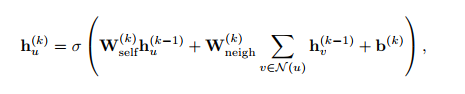


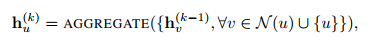

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
embedding_size = 128


class GCN(torch.nn.Module):
  def __init__(self, feature_size):
    super(GCN, self).__init__()
    torch.manual_seed(42) #seed is obviously set to 42

    #Layers
    self.initial_conv = GCNConv(data.num_features, embedding_size)
    self.conv1 = GCNConv(embedding_size, embedding_size)
    self.conv2 = GCNConv(embedding_size, embedding_size)
    self.conv3 = GCNConv(embedding_size, embedding_size)

    #output
    self.out = Linear(embedding_size*2, 1)

  def forward(self, x, edge_index, batch_index):
    #First layer
    x = self.initial_conv(x, edge_index)
    x = F.relu(x)
    #Conv layers
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.conv3(x, edge_index)

    #Global Pooling as mean
    x = torch.cat([global_mean_pool(x, batch_index), global_max_pool(x, batch_index)], dim=1)

    #output
    out = self.out(x)
    out = torch.sigmoid(out)

    return out, x

### Training

In [ ]:
#Data split
train_percent = 0.8
validate_percent = 0.1
train_index = int(train_percent*len(data))
valid_index = int(validate_percent*len(data))

data = data.shuffle()
train_dataset = data[:train_index]
valid_dataset = data[train_index:(train_index+valid_index)]
test_dataset = data[(train_index+valid_index):]

print('Length of train dataset: ', len(train_dataset))
print('Length of validation dataset: ', len(valid_dataset))
print('Length of test dataset: ', len(test_dataset))

Length of train dataset:  1624
Length of validation dataset:  203
Length of test dataset:  203


In [ ]:
import mlflow.pytorch
from torch_geometric.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_gcn = GCN(feature_size=train_dataset[0].x.shape[1])
print(model_gcn)
print("Number of parameters: ", sum(p.numel() for p in model_gcn.parameters()))
model_gcn = model_gcn.to(device)
model_gcn

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_gcn.parameters(), lr=0.001)

#loading data
n_batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=n_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=n_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=n_batch_size, shuffle=True)

def train(epoch):
  all_preds = []
  all_labels = []

  for _, batch in enumerate(tqdm(train_loader)):
    batch.to(device)
    optimizer.zero_grad() #gradients reset

    pred, embedding = model_gcn(batch.x.float(), batch.edge_index, batch.batch)
    #loss = torch.sqrt(loss_fn(pred, batch.y))
    y = batch.y
    y = y.float()
    loss = loss_fn(pred, y)
    #loss = loss_fn(pred, batch.y)
    loss.backward() 
    # Update using the gradients
    optimizer.step() 
    
  return loss, embedding

def valid(epoch):
  all_preds = []
  all_labels = []

  for _, batch in enumerate(tqdm(valid_loader)):
    batch.to(device)
    pred, embedding = model_gcn(batch.x.float(), batch.edge_index, batch.batch)
    y = batch.y
    y = y.float()
    loss = loss_fn(pred, y)
    all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
    all_labels.append(batch.y.cpu().detach().numpy())
  return loss, embedding


def test(epoch):
  all_preds = []
  all_labels = []
  for batch in test_loader:
      batch.to(device)  
      pred, embedding = model_gcn(batch.x.float(), batch.edge_index, batch.batch)
      y = batch.y
      y = y.float()
      loss = loss_fn(pred, y)  
      all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
      all_labels.append(batch.y.cpu().detach().numpy())

  return loss, embedding

GCN(
  (initial_conv): GCNConv(4, 128)
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (out): Linear(in_features=256, out_features=1, bias=True)
)
Number of parameters:  50433


In [ ]:
losses_gcn = []
losses_gcn_valid = []
with mlflow.start_run() as run:
  for epoch in range(100):
    #Training
    model_gcn.train()
    loss, h = train(epoch=epoch)
    loss = loss.detach().cpu().numpy()
    losses_gcn.append(loss)
    print('Epoch: ', epoch)
    print('Train loss: ', loss)
    mlflow.log_metric(key='Train loss', value=float(loss), step=epoch)

    #Validation
    model_gcn.eval()
    if epoch % 5 == 0:
      loss, h = valid(epoch=epoch)
      loss = loss.detach().cpu().numpy()
      losses_gcn_valid.append(loss)
      print('Epoch: ', epoch)
      print('Valid loss: ', loss)
      mlflow.log_metric(key="Valid loss", value=float(loss), step=epoch)
    
      #scheduler.step()
  print("Done.")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  0
Train loss:  0.56339115


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  0
Valid loss:  0.54328066


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  1
Train loss:  0.53102076


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  2
Train loss:  0.5773714


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  3
Train loss:  0.5875791


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  4
Train loss:  0.5437383


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  5
Train loss:  0.5859192


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  5
Valid loss:  0.564883


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  6
Train loss:  0.52016455


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  7
Train loss:  0.5735066


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  8
Train loss:  0.5207287


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  9
Train loss:  0.48104447


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  10
Train loss:  0.5179772


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  10
Valid loss:  0.49231172


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  11
Train loss:  0.49661586


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  12
Train loss:  0.5243312


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  13
Train loss:  0.46808845


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  14
Train loss:  0.50613374


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  15
Train loss:  0.45295814


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  15
Valid loss:  0.5493466


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  16
Train loss:  0.4931107


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  17
Train loss:  0.514284


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  18
Train loss:  0.46875134


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  19
Train loss:  0.55458695


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  20
Train loss:  0.42577562


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  20
Valid loss:  0.55669796


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  21
Train loss:  0.4668439


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  22
Train loss:  0.40202487


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  23
Train loss:  0.356152


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  24
Train loss:  0.5502044


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  25
Train loss:  0.46175668


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  25
Valid loss:  0.46248484


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  26
Train loss:  0.4671049


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  27
Train loss:  0.49553937


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  28
Train loss:  0.43440706


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  29
Train loss:  0.35336912


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  30
Train loss:  0.5253727


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  30
Valid loss:  0.42795295


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  31
Train loss:  0.47510242


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  32
Train loss:  0.47387755


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  33
Train loss:  0.54049134


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  34
Train loss:  0.37957332


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  35
Train loss:  0.3953494


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  35
Valid loss:  0.6206515


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  36
Train loss:  0.43799716


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  37
Train loss:  0.4862161


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  38
Train loss:  0.7075707


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  39
Train loss:  0.4841541


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  40
Train loss:  0.46422103


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  40
Valid loss:  0.49303558


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  41
Train loss:  0.4505806


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  42
Train loss:  0.45307294


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  43
Train loss:  0.5313933


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  44
Train loss:  0.52154404


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  45
Train loss:  0.43360373


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  45
Valid loss:  0.47014654


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  46
Train loss:  0.41403168


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  47
Train loss:  0.33098367


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  48
Train loss:  0.4502038


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  49
Train loss:  0.46290445


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  50
Train loss:  0.55726624


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  50
Valid loss:  0.48616663


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  51
Train loss:  0.46893212


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  52
Train loss:  0.4829978


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  53
Train loss:  0.4676755


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  54
Train loss:  0.5060866


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  55
Train loss:  0.44853383


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  55
Valid loss:  0.5631292


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  56
Train loss:  0.38290456


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  57
Train loss:  0.43282127


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  58
Train loss:  0.5453715


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  59
Train loss:  0.37613288


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  60
Train loss:  0.47585487


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  60
Valid loss:  0.4943731


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  61
Train loss:  0.43011558


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  62
Train loss:  0.5103812


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  63
Train loss:  0.44294435


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  64
Train loss:  0.37810746


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  65
Train loss:  0.46406394


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  65
Valid loss:  0.53170377


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  66
Train loss:  0.57691926


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  67
Train loss:  0.45774382


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  68
Train loss:  0.49022245


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  69
Train loss:  0.4381162


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  70
Train loss:  0.37378553


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  70
Valid loss:  0.58164394


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  71
Train loss:  0.47497442


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  72
Train loss:  0.45432237


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  73
Train loss:  0.4472868


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  74
Train loss:  0.4004569


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  75
Train loss:  0.51685005


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  75
Valid loss:  0.50128156


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  76
Train loss:  0.44864738


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  77
Train loss:  0.38355294


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  78
Train loss:  0.5223564


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  79
Train loss:  0.4185521


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  80
Train loss:  0.46172068


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  80
Valid loss:  0.51472133


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  81
Train loss:  0.41004008


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  82
Train loss:  0.45087603


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  83
Train loss:  0.4909177


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  84
Train loss:  0.37230578


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  85
Train loss:  0.3727928


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  85
Valid loss:  0.45005167


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  86
Train loss:  0.49487865


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  87
Train loss:  0.35114017


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  88
Train loss:  0.47283363


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  89
Train loss:  0.3911402


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  90
Train loss:  0.54529554


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  90
Valid loss:  0.5930164


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  91
Train loss:  0.3679725


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  92
Train loss:  0.39436814


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  93
Train loss:  0.44730866


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  94
Train loss:  0.45977405


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  95
Train loss:  0.30765536


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  95
Valid loss:  0.48913798


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  96
Train loss:  0.45022008


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  97
Train loss:  0.54780596


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  98
Train loss:  0.31171063


100%|██████████| 13/13 [00:04<00:00,  2.85it/s]

Epoch:  99
Train loss:  0.53103834
Done.


In [ ]:
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model_gcn(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    pred = (pred>0.5).int()
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df.head(30)

,y_real,y_pred
0,[1],[1]
1,[1],[1]
2,[1],[1]
3,[1],[1]
4,[1],[1]
5,[1],[1]
6,[0],[0]
7,[0],[1]
8,[1],[1]
9,[1],[1]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


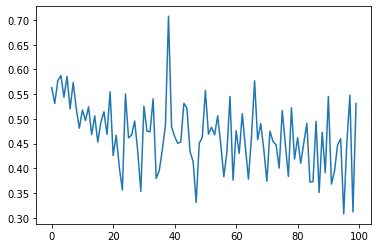

In [ ]:
import seaborn as sns
losses_float_gcn = [float(loss) for loss in losses_gcn] 
loss_indices = [i for i,l in enumerate(losses_float_gcn)] 
plt = sns.lineplot(loss_indices, losses_float_gcn)
plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


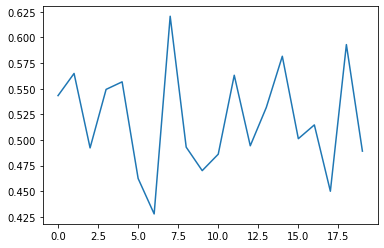

In [ ]:
losses_float_gcn_valid = [float(loss) for loss in losses_gcn_valid] 
loss_indices = [i for i,l in enumerate(losses_float_gcn_valid)] 
plt = sns.lineplot(loss_indices, losses_float_gcn_valid)
plt

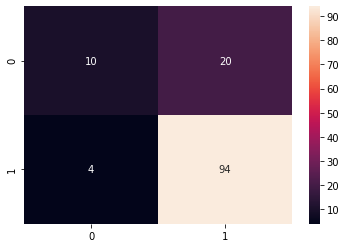

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

flat_true = [value for sublist in df['y_real'].to_numpy() for value in sublist]
flat_pred = [value for sublist in df['y_pred'].to_numpy() for value in sublist]
cm = confusion_matrix(flat_true, flat_pred)
sns.heatmap(cm, annot=True)

In [ ]:
print('\n AOC: ', roc_auc_score(flat_true, flat_pred))
print(classification_report(flat_true, flat_pred))


 AOC:  0.6462585034013606
              precision    recall  f1-score   support

           0       0.71      0.33      0.45        30
           1       0.82      0.96      0.89        98

    accuracy                           0.81       128
   macro avg       0.77      0.65      0.67       128
weighted avg       0.80      0.81      0.79       128



## Graph attention network

### Architecture

Theory

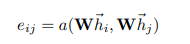

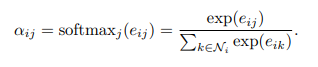

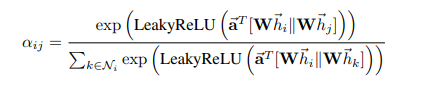

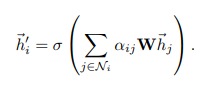

In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GATConv, TopKPooling
from torch_geometric.nn import global_mean_pool
embedding_size = 256


class GAN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GAN, self).__init__()

        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3) 
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)

        # Linear layers
        self.linear1 = Linear(embedding_size, embedding_size)
        self.linear2 = Linear(embedding_size, 1)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # First block
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x,edge_index, None, batch_index)
        x1 = global_mean_pool(x, batch_index)

        # Second block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x,edge_index, None, batch_index)
        x2 = global_mean_pool(x, batch_index)

        # Third block - same weights as the second one
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x,edge_index, None, batch_index)
        x3 = global_mean_pool(x, batch_index)

        # Concatenated pooled representations
        x = x1 + x2 + x3

        # Output 
        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.linear2(x)
        out = torch.sigmoid(x)
        
        return out, x

### Training

In [ ]:
#Data split
train_percent = 0.8
validate_percent = 0.1
train_index = int(train_percent*len(data))
valid_index = int(validate_percent*len(data))

data = data.shuffle()
train_dataset = data[:train_index]
valid_dataset = data[train_index:(train_index+valid_index)]
test_dataset = data[(train_index+valid_index):]

print('Length of train dataset: ', len(train_dataset))
print('Length of validation dataset: ', len(valid_dataset))
print('Length of test dataset: ', len(test_dataset))

Length of train dataset:  1624
Length of validation dataset:  203
Length of test dataset:  203


In [ ]:
import mlflow.pytorch
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
import mlflow.pytorch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_gan = GAN(feature_size=train_dataset[0].x.shape[1])
print(model_gan)
print("Number of parameters: ", sum(p.numel() for p in model_gan.parameters()))
model_gan = model_gan.to(device)
model_gan

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_gan.parameters(), lr=0.0001) #od razu zmniejszony o rzad wielkosci

#loading data
train_loader = DataLoader(train_dataset, batch_size=n_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=n_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=n_batch_size, shuffle=True)

def train(epoch):
  all_preds = []
  all_labels = []

  for _, batch in enumerate(tqdm(train_loader)):
    batch.to(device)
    optimizer.zero_grad() #gradients reset

    pred, embedding = model_gan(batch.x.float(), batch.edge_attr.float(), batch.edge_index, batch.batch)
    #loss = torch.sqrt(loss_fn(pred, batch.y))
    y = batch.y
    y = y.float()
    loss = loss_fn(pred, y)
    #loss = loss_fn(pred, batch.y)
    loss.backward()  
    # Update using the gradients
    optimizer.step() 
    
  return loss, embedding

def valid(epoch):
  all_preds = []
  all_labels = []

  for _, batch in enumerate(tqdm(valid_loader)):
    batch.to(device)
    pred, embedding = model_gan(batch.x.float(), batch.edge_attr.float(), batch.edge_index, batch.batch)
    y = batch.y
    y = y.float()
    loss = loss_fn(pred, y)
    all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
    all_labels.append(batch.y.cpu().detach().numpy())
  return loss, embedding


def test(epoch):
  all_preds = []
  all_labels = []
  for batch in test_loader:
      batch.to(device)  
      pred, embedding = model_gan(batch.x.float(), batch.edge_attr.float(), batch.edge_index, batch.batch)
      y = batch.y
      y = y.float()
      #loss = torch.sqrt(loss_fn(pred, batch.y))
      loss = loss_fn(pred, y)  
      all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
      all_labels.append(batch.y.cpu().detach().numpy())

  return loss, embedding

GAN(
  (conv1): GATConv(4, 256, heads=3)
  (head_transform1): Linear(in_features=768, out_features=256, bias=True)
  (pool1): TopKPooling(256, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(256, 256, heads=3)
  (head_transform2): Linear(in_features=768, out_features=256, bias=True)
  (pool2): TopKPooling(256, ratio=0.5, multiplier=1.0)
  (pool3): TopKPooling(256, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=256, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)
Number of parameters:  664833


For embedding of 512 with last layer with 1024 parameters: 3427841

For embedding of 512: 2902529

For embedding of 256: 730369

In [ ]:
losses_gan = []
losses_gan_valid = []
with mlflow.start_run() as run:
  for epoch in range(50):
    #Training
    model_gan.train()
    loss, h = train(epoch=epoch)
    loss = loss.detach().cpu().numpy()
    losses_gan.append(loss)
    print('Epoch: ', epoch)
    print('Train loss: ', loss)
    mlflow.log_metric(key='Train loss', value=float(loss), step=epoch)

    #Validation
    model_gan.eval()
    if epoch % 5 == 0:
      loss, h = valid(epoch=epoch)
      loss = loss.detach().cpu().numpy()
      losses_gan_valid.append(loss)
      print('Epoch: ', epoch)
      print('Valid loss: ', loss)
      mlflow.log_metric(key="Valid loss", value=float(loss), step=epoch)
    
      #scheduler.step()
  print("Done.")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  0
Train loss:  0.580611


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  0
Valid loss:  0.60302263


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  1
Train loss:  0.5701107


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  2
Train loss:  0.47009125


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  3
Train loss:  0.6111376


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  4
Train loss:  0.593937


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  5
Train loss:  0.53446573


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  5
Valid loss:  0.6256878


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  6
Train loss:  0.5214921


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  7
Train loss:  0.6222963


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  8
Train loss:  0.50751776


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  9
Train loss:  0.52374256


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  10
Train loss:  0.49874792


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  10
Valid loss:  0.43870917


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  11
Train loss:  0.5519942


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  12
Train loss:  0.43049508


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  13
Train loss:  0.50707203


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  14
Train loss:  0.6311116


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  15
Train loss:  0.49021465


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  15
Valid loss:  0.4931693


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  16
Train loss:  0.47230884


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  17
Train loss:  0.50370914


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  18
Train loss:  0.57277733


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  19
Train loss:  0.4898798


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  20
Train loss:  0.55016285


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  20
Valid loss:  0.4828728


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  21
Train loss:  0.59143066


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  22
Train loss:  0.46680295


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  23
Train loss:  0.5529576


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  24
Train loss:  0.5241749


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  25
Train loss:  0.5164179


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  25
Valid loss:  0.5368718


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  26
Train loss:  0.44930476


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  27
Train loss:  0.75125045


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  28
Train loss:  0.5739246


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  29
Train loss:  0.5323403


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  30
Train loss:  0.437496


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  30
Valid loss:  0.59726936


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  31
Train loss:  0.49328965


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  32
Train loss:  0.450053


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  33
Train loss:  0.49772123


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  34
Train loss:  0.44019145


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  35
Train loss:  0.50293076


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  35
Valid loss:  0.53105783


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  36
Train loss:  0.5125694


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  37
Train loss:  0.64334995


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  38
Train loss:  0.4901415


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  39
Train loss:  0.59193873


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  40
Train loss:  0.46348304


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  40
Valid loss:  0.5037539


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  41
Train loss:  0.45972812


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  42
Train loss:  0.44389507


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  43
Train loss:  0.6479073


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  44
Train loss:  0.44079638


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:  45
Train loss:  0.39494342


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  45
Valid loss:  0.57053417


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  46
Train loss:  0.6265224


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  47
Train loss:  0.4801749


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch:  48
Train loss:  0.501703


100%|██████████| 13/13 [00:14<00:00,  1.13s/it]

Epoch:  49
Train loss:  0.45787856
Done.


In [ ]:
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model_gan(test_batch.x.float(), test_batch.edge_attr.float(), test_batch.edge_index, test_batch.batch)
    pred = (pred>0.5).int()
    df2 = pd.DataFrame()
    df2["y_real"] = test_batch.y.tolist()
    df2["y_pred"] = pred.tolist()
df2.head(30)

,y_real,y_pred
0,[1],[1]
1,[1],[1]
2,[0],[1]
3,[1],[1]
4,[1],[1]
5,[1],[1]
6,[1],[1]
7,[1],[1]
8,[1],[1]
9,[1],[1]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


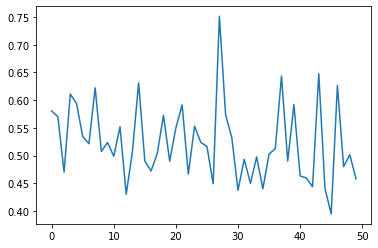

In [ ]:
losses_float_gan = [float(loss) for loss in losses_gan] 
loss_indices = [i for i,l in enumerate(losses_float_gan)] 
plt = sns.lineplot(loss_indices, losses_float_gan)
plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


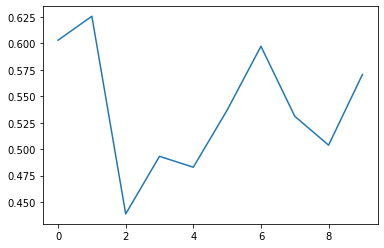

In [ ]:
losses_float_gan_valid = [float(loss) for loss in losses_gan_valid] 
loss_indices = [i for i,l in enumerate(losses_float_gan_valid)] 
plt = sns.lineplot(loss_indices, losses_float_gan_valid)
plt

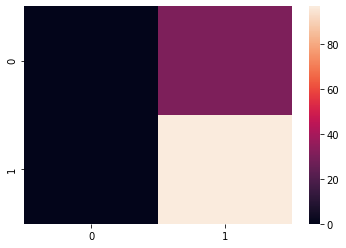

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_confusion_matrix, classification_report

flat_true2 = [value for sublist in df2['y_real'].to_numpy() for value in sublist]
flat_pred2 = [value for sublist in df2['y_pred'].to_numpy() for value in sublist]
cm = confusion_matrix(flat_true2, flat_pred2)
sns.heatmap(cm)

In [ ]:
print('\n AOC: ', roc_auc_score(flat_true2, flat_pred2))
print(classification_report(flat_true2, flat_pred2))


 AOC:  0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.76      1.00      0.86        97

    accuracy                           0.76       128
   macro avg       0.38      0.50      0.43       128
weighted avg       0.57      0.76      0.65       128



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusions